In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
wave_len = 1600
window_size = 4
data_dim = 2
latent_dim = 64

In [3]:
def res_block(inputs, filters, kernel_size, strides=(1, 1), activation=tf.nn.relu, kernel_initializer=None):
    x = inputs

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x)

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x + inputs)

    return x

def leaky_relu(x, alpha):
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def encoder(inputs):
    h = 256
    initializer = tf.random_normal_initializer(0, 0.02)

    x = inputs

    # -------
    x = tf.layers.conv2d(x, h, kernel_size=(window_size, 1), strides=(1, 1), padding="same", kernel_initializer=initializer) # 2->h
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 1600*1*h -> 400*1*h
    
    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 400*1*h -> 100*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 100*1*h -> 25*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)

    # -------
    x = tf.reshape(x, shape=(-1, h * 25))
    x = tf.layers.dense(x, latent_dim, kernel_initializer=initializer) # 1024
    
    x = tf.nn.tanh(x)

    return x

def decoder(inputs):
    h = 256
    initializer = tf.random_normal_initializer(0, 0.02)
    
    x = inputs # 1600
    
    # -------
    x = tf.layers.dense(x, h * 25, kernel_initializer=initializer) # 64*25 = 1600
    x = tf.reshape(x, shape=(-1, 25, 1, h)) # 25*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 100*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 400*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 4, x.shape[2])) # 1600*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.conv2d(x, data_dim, kernel_size=1, padding="same", kernel_initializer=initializer)

    return x

In [4]:
inputs = tf.placeholder(tf.float32, (None, wave_len, data_dim))

encoded = encoder(tf.reshape(inputs, (-1, wave_len, 1, data_dim)))
decoded = tf.reshape(decoder(encoded), (-1, wave_len, data_dim))

In [5]:
inputs_fft_0 = tf.fft(tf.cast(inputs[:,:,0],tf.complex64))
inputs_fft_1 = tf.fft(tf.cast(inputs[:,:,1],tf.complex64))
decoded_fft_0 = tf.fft(tf.cast(decoded[:,:,0],tf.complex64))
decoded_fft_1 = tf.fft(tf.cast(decoded[:,:,1],tf.complex64))

# loss = tf.reduce_mean(tf.pow(inputs - decoded, 2))

In [6]:
# lr = 8e-4
# beta1= 0.5
# beta2 = 0.9
# loss = tf.reduce_mean(tf.pow(tf.abs(inputs_fft_0 - decoded_fft_0),2)+tf.pow(tf.abs(inputs_fft_1 - decoded_fft_1),2)) # pow
loss = tf.reduce_mean(tf.log(tf.log(tf.abs(inputs_fft_0 - decoded_fft_0)+1)+1)+tf.log(tf.log(tf.abs(inputs_fft_1 - decoded_fft_1)+1)+1))
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

(10370160, 2) 48000


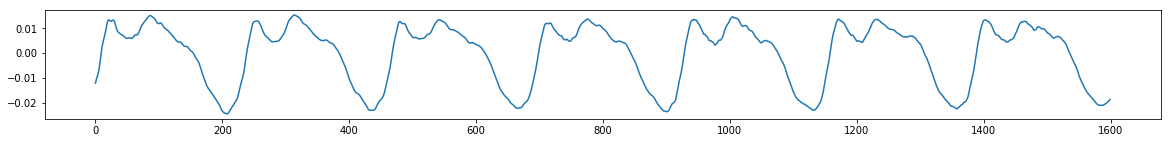

['../VoiceData/tamaneuta/trim_data/utama1.wav',
 '../VoiceData/tamaneuta/trim_data/utama2.wav',
 '../VoiceData/tamaneuta/trim_data/utama3.wav',
 '../VoiceData/tamaneuta/trim_data/utama4.wav',
 '../VoiceData/tamaneuta/trim_data/utama5.wav',
 '../VoiceData/tamaneuta/trim_data/utama6.wav',
 '../VoiceData/tamaneuta/trim_data/utama7.wav',
 '../VoiceData/tamaneuta/trim_data/utama8.wav',
 '../VoiceData/tamaneuta/trim_data/utama9.wav']

In [7]:
import soundfile as sf
import os

path = "../VoiceData/tamaneuta/trim_data/"
files = sorted(os.listdir(path))
files = [path + file for file in files]

data1, rate = sf.read(files[0]) # rate == 48000 # samplerate:1秒あたりのフレーム数
print(data1.shape, rate)
_s = 1000000
_data1 = data1[_s:_s+wave_len,0]
plt.figure(figsize=(20,2));plt.plot(_data1);plt.show()

files

In [8]:
import random

class Generator(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
        
        for i in range(0, int(len(wave)/wave_len)):
            _data = wave[i*wave_len:(i+1)*wave_len]
            _amp = np.max(np.abs(_data))
            if NO_SILENT and _amp < 0.005: # 無音を捨てる
                continue
            data.append(_data/_amp)
            amp.append(_amp)

        if shuffle:
            temp = list(zip(data, amp))
            np.random.shuffle(temp)
            data, amp = zip(*temp)
        
        data = np.array(data)
        amp = np.array(amp)
        
        if DEMO:
            print("wave")
            for i in range(3):
                print(amp[i])
                plt.figure(figsize=(20,1))
                plt.plot(data[i])
                plt.show()
                
            print("amp")
            # file番号によって変わる
            plt.figure(figsize=(3,2))
            plt.hist(amp, bins=500)
            plt.axvline(0.005, color="r")
            plt.show()
            
        if DEMO:
            print("data.shape ==", data.shape)
            print("amp.shape ==", amp.shape)

        return data, amp
    
gen = Generator()

In [9]:
class Generator_for_realtime(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
        t = 0
        while t < len(wave):
            _data = wave[t:t+wave_len]
            
            t += wave_len - 20*2 - 40 # 20==切り捨てる量, 40==かぶせる量
            
            if not len(_data) == wave_len:
                continue
            _amp = np.max(np.abs(_data))
            
            data.append(_data/_amp)
            amp.append(_amp)
            

        data = np.array(data)
        amp = np.array(amp)
        
        return data, amp

In [10]:
gen = Generator()
# gen = Generator_for_realtime()
data, amp = gen.generate(0)
data.shape

(5672, 1600, 2)

wave
0.018585205078125


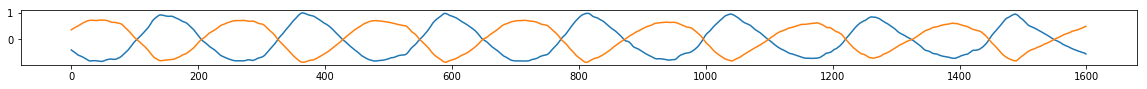

0.020965576171875


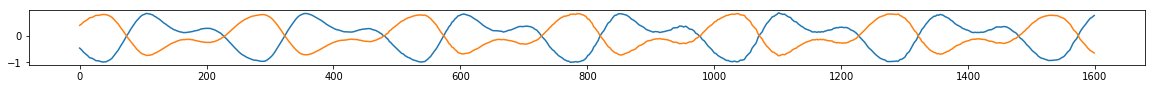

0.037109375


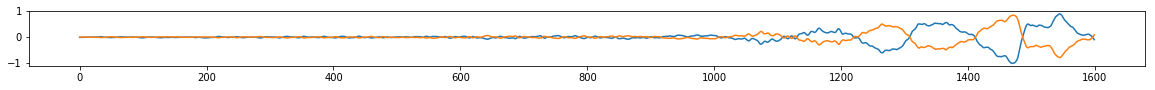

amp


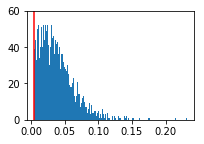

data.shape == (5672, 1600, 2)
amp.shape == (5672,)


In [11]:
data, amp = gen.generate(0, DEMO=True)

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
# saver.restore(sess, './model/model-c-89')

batch_size = 128
epoch = 0

In [13]:
max_epoch = 10

In [14]:
for _ in range(epoch, max_epoch):    
    for file in range(len(files)):
        data, _ = gen.generate(file)
        loss_hist = []
        for index in tqdm(range(0, len(data), batch_size)):
            batch = data[index:index+batch_size]
            _, _loss = sess.run([optimize, loss], {inputs: batch})
            loss_hist.append(_loss)
        print("epoch:", epoch+1, "file:", file+1, ", loss_sum:", np.mean(loss_hist))
    epoch += 1
    saver.save(sess, './model/model', global_step=epoch+1)

100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


epoch: 1 file: 1 , loss_sum: 0.69448084


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 1 file: 2 , loss_sum: 0.5416946


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 1 file: 3 , loss_sum: 0.52827394


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 4 , loss_sum: 0.52596164


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1 file: 5 , loss_sum: 0.5128549


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 6 , loss_sum: 0.5472013


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 7 , loss_sum: 0.5510953


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 8 , loss_sum: 0.5192328


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


epoch: 1 file: 9 , loss_sum: 0.5109548


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 2 file: 1 , loss_sum: 0.48229557


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 2 file: 2 , loss_sum: 0.49587375


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 2 file: 3 , loss_sum: 0.5060781


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 4 , loss_sum: 0.51135534


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 2 file: 5 , loss_sum: 0.5015041


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 6 , loss_sum: 0.5379307


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 7 , loss_sum: 0.53351766


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 8 , loss_sum: 0.51375854


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


epoch: 2 file: 9 , loss_sum: 0.50524133


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 3 file: 1 , loss_sum: 0.4770618


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 3 file: 2 , loss_sum: 0.48436677


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 3 file: 3 , loss_sum: 0.508225


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3 file: 4 , loss_sum: 0.5027408


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 3 file: 5 , loss_sum: 0.4964955


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3 file: 6 , loss_sum: 0.5266396


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 7 , loss_sum: 0.52544355


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 8 , loss_sum: 0.5051269


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


epoch: 3 file: 9 , loss_sum: 0.49581605


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 4 file: 1 , loss_sum: 0.46876067


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 4 file: 2 , loss_sum: 0.47651428


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 4 file: 3 , loss_sum: 0.49180928


100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


epoch: 4 file: 4 , loss_sum: 0.5000617


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 4 file: 5 , loss_sum: 0.48552224


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4 file: 6 , loss_sum: 0.52313304


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 7 , loss_sum: 0.518801


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 8 , loss_sum: 0.49686334


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


epoch: 4 file: 9 , loss_sum: 0.48650804


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 5 file: 1 , loss_sum: 0.46818152


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 5 file: 2 , loss_sum: 0.47569486


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 5 file: 3 , loss_sum: 0.49061504


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5 file: 4 , loss_sum: 0.48940936


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 5 file: 5 , loss_sum: 0.48659292


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


epoch: 5 file: 6 , loss_sum: 0.51618594


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 7 , loss_sum: 0.5183476


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 8 , loss_sum: 0.49752948


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


epoch: 5 file: 9 , loss_sum: 0.48671806


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 6 file: 1 , loss_sum: 0.45528892


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 6 file: 2 , loss_sum: 0.4721213


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 6 file: 3 , loss_sum: 0.48824546


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 4 , loss_sum: 0.4823527


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 6 file: 5 , loss_sum: 0.47924984


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 6 , loss_sum: 0.5181024


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 7 , loss_sum: 0.5139587


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 8 , loss_sum: 0.4916854


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


epoch: 6 file: 9 , loss_sum: 0.48715118


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 7 file: 1 , loss_sum: 0.4563855


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 7 file: 2 , loss_sum: 0.46625483


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 7 file: 3 , loss_sum: 0.48352727


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 4 , loss_sum: 0.48550162


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 7 file: 5 , loss_sum: 0.48463145


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 6 , loss_sum: 0.51573867


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 7 , loss_sum: 0.5137393


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 8 , loss_sum: 0.49045295


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


epoch: 7 file: 9 , loss_sum: 0.48314577


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 8 file: 1 , loss_sum: 0.45927948


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 8 file: 2 , loss_sum: 0.46650863


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 8 file: 3 , loss_sum: 0.48656923


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 4 , loss_sum: 0.4832506


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 8 file: 5 , loss_sum: 0.47697988


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 6 , loss_sum: 0.5115381


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 7 , loss_sum: 0.5135564


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 8 , loss_sum: 0.4948284


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


epoch: 8 file: 9 , loss_sum: 0.48351035


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 9 file: 1 , loss_sum: 0.4548336


100%|██████████| 49/49 [00:40<00:00,  1.21it/s]


epoch: 9 file: 2 , loss_sum: 0.46274957


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 9 file: 3 , loss_sum: 0.4805117


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


epoch: 9 file: 4 , loss_sum: 0.47847027


100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


epoch: 9 file: 5 , loss_sum: 0.47558308


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9 file: 6 , loss_sum: 0.51266444


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 7 , loss_sum: 0.5123102


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 8 , loss_sum: 0.4866074


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


epoch: 9 file: 9 , loss_sum: 0.4803518


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 10 file: 1 , loss_sum: 0.45184213


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 10 file: 2 , loss_sum: 0.4652512


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 10 file: 3 , loss_sum: 0.4818121


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 4 , loss_sum: 0.48096886


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 10 file: 5 , loss_sum: 0.48091576


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 6 , loss_sum: 0.5099124


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 7 , loss_sum: 0.5078175


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 8 , loss_sum: 0.48706016


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


epoch: 10 file: 9 , loss_sum: 0.47553036


In [14]:
# saver.save(sess, './model/model-A', global_step=epoch)

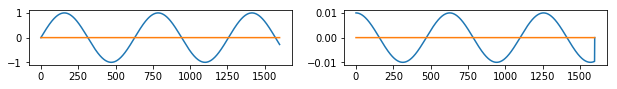

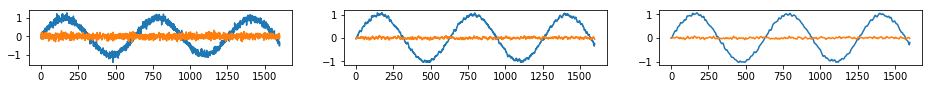

In [15]:
def df(f):
    df = np.zeros((len(f),2))
    df[:-1] = f[1:] - f[:-1]
    return df

def denoise(f):
    v = np.ones(8)/8
    f = np.array([np.convolve(fi,v, mode='same') for fi in f.T]).T
    return f

_x = np.zeros((1600,2))
_x[:,0] = np.sin(np.arange(1600)/100.0) # y = sin(x/100) dy/dx = 1/100*cos(x/100)
plt.figure(figsize=(16,1))
plt.subplot(1,3,1); plt.plot(_x)
plt.subplot(1,3,2); plt.plot(df(_x)); plt.show()

_x = np.zeros((1600,2))
_x[:,0] = np.sin(np.arange(1600)/100.0)
_x += np.random.randn(1600,2)/10
plt.figure(figsize=(16,1))
plt.subplot(1,3,1); plt.plot(_x)
plt.subplot(1,3,2); plt.plot(denoise(_x))
plt.subplot(1,3,3); plt.plot(denoise(denoise(_x))); plt.show()

(1600, 2) amp: 0.03466796875 

original -> df -> ddf


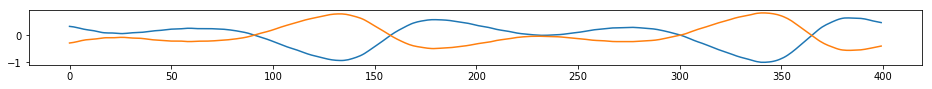

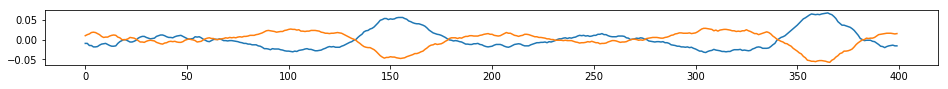

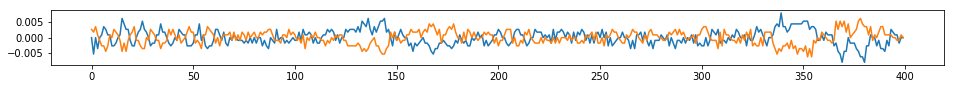

autoencoded -> df -> ddf


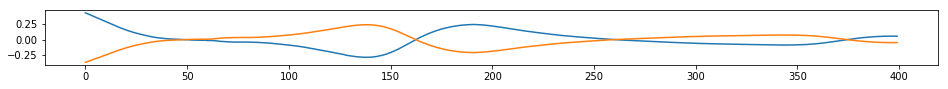

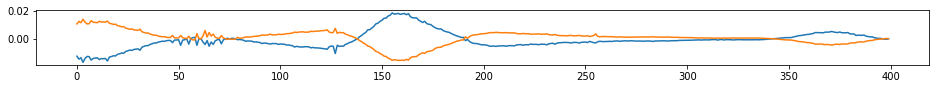

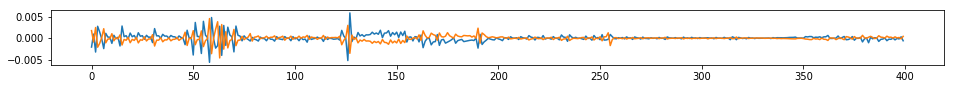

In [16]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a, "\n")
_x = x.reshape(wave_len, data_dim)
print("original -> df -> ddf")
plt.figure(figsize=(16,1)); plt.plot(_x[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(_x)[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(df(_x))[:400]); plt.show()

x = sess.run(decoded, {inputs: [_x]})
x = x[0].reshape(wave_len, data_dim)
print("autoencoded -> df -> ddf")
plt.figure(figsize=(16,1)); plt.plot(x[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(x)[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(df(x))[:400]); plt.show()

(1600, 2) amp: 0.05194091796875
inputs


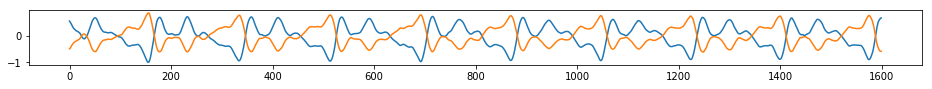

decoded


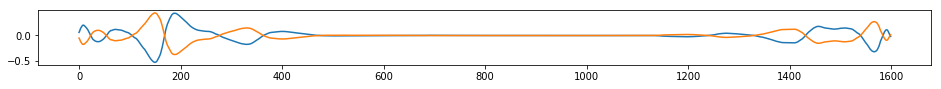

inputs_fft


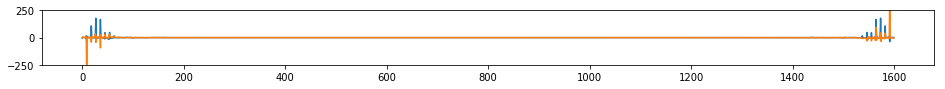

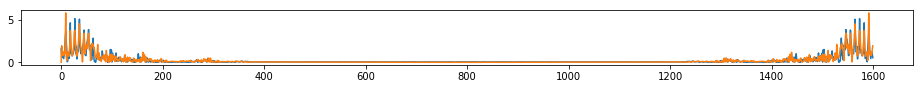

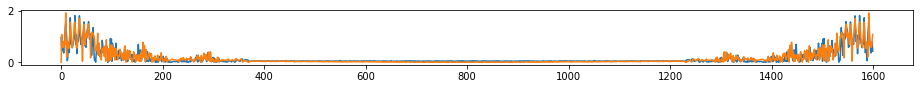

decoded_fft


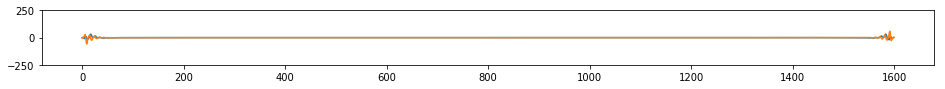

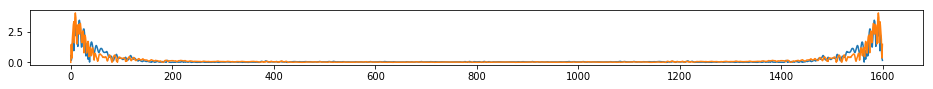

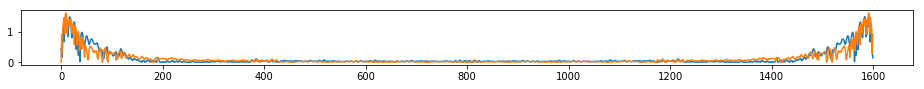

In [17]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a)

_x = x.reshape(wave_len, data_dim)
print("inputs")
plt.figure(figsize=(16,1)); plt.plot(_x); plt.show()

x = sess.run(decoded, {inputs: [_x]})
print("decoded")
plt.figure(figsize=(16,1)); plt.plot(x[0]); plt.show()

x = sess.run(inputs_fft_0, {inputs: [_x]})
print("inputs_fft")
A1 = np.real(x.T)
A2 = np.imag(x.T)
plt.figure(figsize=(16,1)); plt.ylim([-250,250]); plt.plot(A1); plt.plot(A2); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.abs(A1)+1)); plt.plot(np.log(np.abs(A2)+1)); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.log(np.abs(A1)+1)+1)); plt.plot(np.log(np.log(np.abs(A2)+1)+1)); plt.show()

x = sess.run(decoded_fft_0, {inputs: [_x]})
print("decoded_fft")
B1 = np.real(x.T)
B2 = np.imag(x.T)
plt.figure(figsize=(16,1)); plt.ylim([-250,250]); plt.plot(B1); plt.plot(B2); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.abs(B1)+1)); plt.plot(np.log(np.abs(B2)+1)); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.log(np.abs(B1)+1)+1)); plt.plot(np.log(np.log(np.abs(B2)+1)+1)); plt.show()

fft_diff


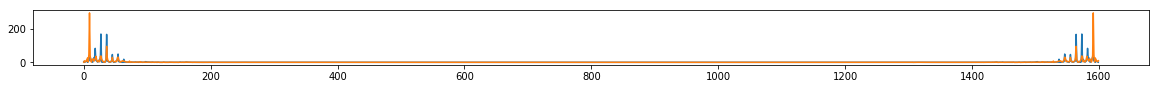

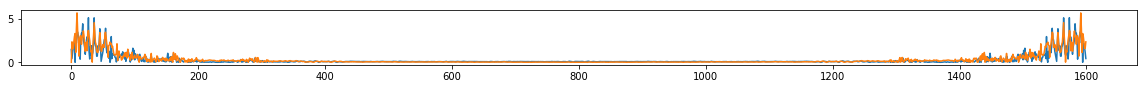

In [18]:
print("fft_diff")
plt.figure(figsize=(20,1)); plt.plot(np.abs(A1-B1)); plt.plot(np.abs(A2-B2)); plt.show()
plt.figure(figsize=(20,1)); plt.plot(np.log(np.abs(A1-B1)+1)); plt.plot(np.log(np.abs(A2-B2)+1)); plt.show()
# plt.figure(figsize=(20,1)); plt.plot(np.log(np.log(np.abs(A1-B1)+1)+1)); plt.plot(np.log(np.log(np.abs(A2-B2)+1)+1)); plt.show()

### AutoEncode

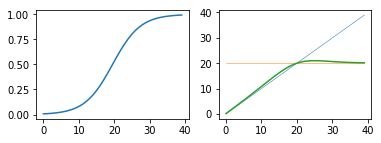

In [19]:
def sigmoid(size):
    x = np.linspace(0,1,size)
    x = (x - np.mean(x))*10
    y = 1 / (1 + np.e**-x)
    return y

def connect(a, b, DEMO=False):
    w = sigmoid(40)
    c = a*np.array([(1-w)]) + b*np.array([w])
    return c[0]

plt.figure(figsize=(6,2)); 
plt.subplot(1,2,1); plt.plot(sigmoid(40))
a = np.arange(0,40); b = np.ones(40)*20
plt.subplot(1,2,2); plt.plot(a, linewidth=0.5); plt.plot(b, linewidth=0.5); plt.plot(connect(a,b)); plt.show()

In [20]:
gen = Generator()

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = gen.generate(fi, shuffle=False, NO_SILENT=False)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 1600,2):
            continue
            
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))
#         _ae_data = np.array([denoise(_data) for _data in _ae_data])
#         _ae_data = np.array([denoise(_data) for _data in _ae_data]) # denoise2回する
#         ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))

ae_data = np.array(ae_data).reshape(-1, data_dim)
print(ae_data.shape)
sf.write("sample/temp_fftloglogloss_256filters_10epoch.wav", ae_data, rate)

100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


(10240000, 2)


In [26]:
gen = Generator_for_realtime()

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = gen.generate(0)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 1600,2):
            continue
        # denoiseしない方が良い
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))
#         _ae_data = np.array([denoise(_data) for _data in _ae_data])
#         _ae_data = np.array([denoise(_data) for _data in _ae_data]) # denoise2回する
#         ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))

100%|██████████| 54/54 [00:02<00:00, 22.74it/s]


In [28]:
ae_data = np.array(ae_data)
print(ae_data.shape)

(6784, 1600, 2)


### vstackが遅延の原因

In [120]:
# concat_data = ae_data[0, 20:-20]

# for _ae_data in tqdm(ae_data[1:]):
#     _ae_data = _ae_data[20:-20] # 新しいデータ。最初と最後は切り捨てておく。(1560, 2)
#     a = concat_data[-40:] # 古いデータの尻。(40, 2)
#     b = _ae_data[:40] # 新しいデータの頭。(40, 2)
#     concat_data[-40:,0] = connect(a[:,0],b[:,0]) # 古いデータを上書き
#     concat_data[-40:,1] = connect(a[:,1],b[:,1]) # 古いデータを上書き
#     concat_data = np.vstack([concat_data, _ae_data[40:]])

100%|██████████| 6783/6783 [03:07<00:00, 36.11it/s] 


In [29]:
concat_data = [ae_data[0, 60:-20]]

for _ae_data in tqdm(ae_data[1:]):
    _ae_data = _ae_data[20:-20] # 新しいデータ。最初と最後は切り捨てておく。(1560, 2)
    a = concat_data[-1][-40:] # 古いデータの尻。(40, 2)
    b = _ae_data[:40] # 新しいデータの頭。(40, 2)
    concat_data[-1][-40:,0] = connect(a[:,0],b[:,0]) # 古いデータを上書き
    concat_data[-1][-40:,1] = connect(a[:,1],b[:,1]) # 古いデータを上書き
#     concat_data = np.vstack([concat_data, _ae_data[40:]])
    
    concat_data.append(_ae_data[40:])

100%|██████████| 6783/6783 [00:00<00:00, 11009.60it/s]


In [31]:
concat_data = np.array(concat_data).reshape(-1, data_dim)
sf.write("sample/concat_mini_fftpowloss_20epoch.wav", concat_data[:int(len(concat_data)/3.58/3)], rate)

In [121]:
sf.write("sample/concat_mini_no-denoise.wav", concat_data[:int(len(concat_data)/3.58/3)], rate)

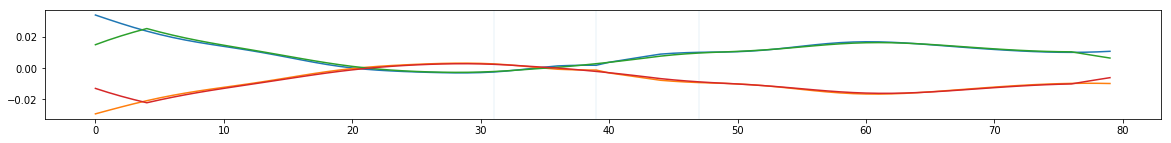

-644683837890609/100000000000000000 160095095634457/25000000000000000
1418471336364648/4303455352781 478153460647937631786800921/4303455352781000000000000000
51121413707733/12500000000000000 -438123941421507/100000000000000000
2097641980206/1079727102209 623866761049774055080315857/53986355110450000000000000000


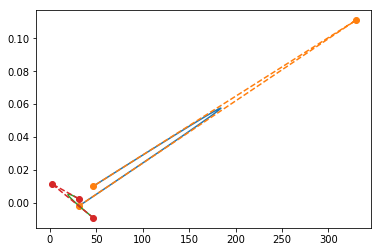

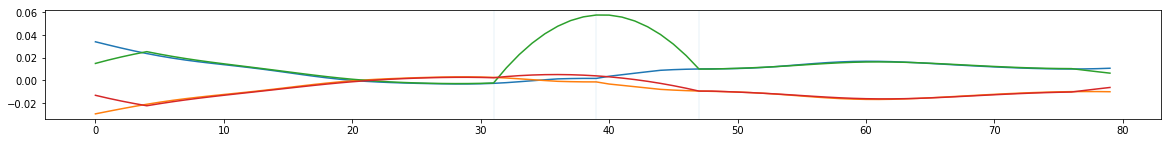

In [374]:
k = np.random.randint(54*128)
plt.figure(figsize=(20,2))
# plt.plot(ae_data[k*1600:(k+1)*1600])

w = 40

_X = ae_data[k*1600-w:k*1600+w]

X = denoise(_X)

plt.plot(_X)
plt.plot(X)
plt.axvline(w-1, linewidth=0.1)
plt.axvline(w-1+8, linewidth=0.1)
plt.axvline(w-1-8, linewidth=0.1)
plt.show()


p1 = [30, X[30,0]]
p3 = [32, X[32,0]]
p2 = [46, X[47,0]]
p4 = [48, X[49,0]]

pa = [31, X[31,0]]
pb = [47, X[48,0]]
pc = cross_point(Point(p1), Point(p2), Point(p3), Point(p4))

q = np.array([pa, pc, pb], dtype=np.float)

list = []
for t in np.linspace(0, 1, 17):
    list.append(bezier(2, t, q))
P1 = np.array(list)

plt.plot(P1.T[0], P1.T[1])
plt.plot(q.T[0], q.T[1], '--o')

p1 = [30, X[30,1]]
p3 = [32, X[32,1]]
p2 = [46, X[47,1]]
p4 = [48, X[49,1]]

pa = [31, X[31,1]]
pb = [47, X[48,1]]
pc = cross_point(Point(p1), Point(p2), Point(p3), Point(p4))

q = np.array([pa, pc, pb], dtype=np.float)

list = []
for t in np.linspace(0, 1, 17):
    list.append(bezier(2, t, q))
P2 = np.array(list)

plt.plot(P2.T[0], P2.T[1])
plt.plot(q.T[0], q.T[1], '--o')
plt.show()

plt.figure(figsize=(20,2))
plt.plot(_X)
plt.axvline(w-1, linewidth=0.1)
plt.axvline(w-1+8, linewidth=0.1)
plt.axvline(w-1-8, linewidth=0.1)

X[31:48,0] = P1.T[1]
X[31:48,1] = P2.T[1]
plt.plot(X); plt.show()

In [154]:
from sympy import *
sg1,sg2 = Segment( Point(0,0), Point(1,1)),Segment( Point(0,1), Point(1,0))
ls = intersection(sg1,sg2)
print(ls)

ls = intersection(sg1,sg2)[0]
print(ls,ls.x,ls.y)

sg1,sg2 = Segment( Point(0,0), Point(0.3,0.3)), Segment( Point(0,1), Point(1,0))
ls = intersection(sg1,sg2)
print(ls)

[Point2D(1/2, 1/2)]
Point2D(1/2, 1/2) 1/2 1/2
[]


In [266]:
def cross_point(p1, p2, p3, p4):
    s1 = ((p4.x - p2.x) * (p1.y - p2.y) - (p4.y - p2.y) * (p1.x - p2.x))/2
    s2 = ((p4.x - p2.x) * (p2.y - p3.y) - (p4.y - p2.y) * (p2.x - p3.x))/2
    print(s1, s2)
    (x,y) =  p1.x + (p3.x - p1.x) * s1 / (s1 + s2), p1.y + (p3.y - p1.y) * s1 / (s1 + s2)
    print(x,y)
    return [x,y]
cross_point(Point([0,0]), Point(0,5), Point(0.1,0.1), Point(-1,0))

5/2 -27/10
-5/4 -5/4


[-5/4, -5/4]

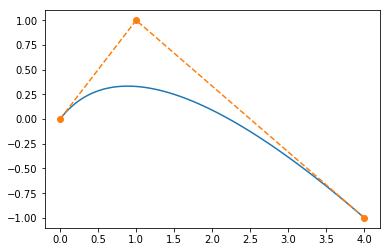

In [132]:
import scipy.special as scs
import numpy as np
import matplotlib.pyplot as plt

def bernstein(n, i, t):
    return scs.comb(n, i) * t**i * (1 - t)**(n-i)

def bezier(n, t, q):
    p = np.zeros(2)
    for i in range(n + 1):
        p += bernstein(n, i, t) * q[i]
    return p

q = np.array([[0, 0], [1, 1], [4, -1]], dtype=np.float)

list = []
for t in np.linspace(0, 1, 100):
    list.append(bezier(2, t, q))
P = np.array(list)

plt.plot(P.T[0], P.T[1])
plt.plot(q.T[0], q.T[1], '--o')
plt.show()